## Option prices

### Convert JSON to Pandas Data Frame

The JSON files are downloaded from API calls like this:
https://history.deribit.com/api/v2/public/get_last_trades_by_instrument?instrument_name=BTC-31MAR23-30000-C&count=10000&include_old=true 
The date range is a year from the 30th of March 2023.
Easy to convert via https://www.epochconverter.com/

In [162]:
import pandas as pd
import plotly.graph_objects as go
import requests

printData = False

In [163]:
def getDFfromOptionJson(fileName):
    df = pd.read_json(fileName)

    df = pd.json_normalize(df.result.trades)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms').dt.date
    df = df.drop_duplicates(subset=['timestamp'])

    df = df.loc[:, ['timestamp', 'price']].copy()
    df['percent_change_option'] = df['price'].pct_change(-1) * 100
    return df
      

In [164]:
df30 = getDFfromOptionJson('get_last_trades_by_BTC-31MAR23-20000-C.json')
if printData: print(df30)

In [165]:
# from https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=1d&startTime=1676505600&endTime=1680134400000

btc_ohlc = pd.read_json('btc-ohlc.json')
btc_ohlc[0] = pd.to_datetime(btc_ohlc[0], unit='ms').dt.date

btc_ohlc = btc_ohlc.loc[:, [0, 4]].copy()
btc_ohlc['percent_change_btc'] = btc_ohlc[4].pct_change(-1) * 100

if printData: print(btc_ohlc)

In [166]:
def getMergedDF(df):
    merged_df = pd.merge(df, btc_ohlc, left_on='timestamp', right_on=0)

    merged_df.drop(0, axis=1, inplace=True)
    merged_df.rename({'price': 'price_option', 4: 'price_btc'}, axis=1, inplace=True)
    merged_df['price_option_in_usd'] = merged_df['price_option'] * merged_df['price_btc']
    return merged_df


In [167]:
mergedDF30 = getMergedDF(df30)

if printData: print(mergedDF30)

### Show prices

In [168]:
def showFig(fileName, title):
    df = getDFfromOptionJson(fileName)
    merged_df = getMergedDF(df)
    
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=merged_df['timestamp'], 
                              y=merged_df['price_option_in_usd'], 
                              name='Option price', yaxis='y', line=dict(color="red")))
    fig.add_trace(go.Scatter(x=merged_df['timestamp'], 
                              y=merged_df['price_btc'], 
                              name='BTC price in USD', yaxis='y2', line=dict(color="blue")))
    fig.add_trace(go.Scatter(x=merged_df['timestamp'], 
                              y=merged_df['price_option'], 
                              name='BTC price in BTC', yaxis='y3', line=dict(color="green")))


    fig.update_layout(width=1300, height=800)

    fig.update_layout(title=title,
                      yaxis=dict(title='Option price', range=[merged_df['price_option_in_usd'].min(), merged_df['price_option_in_usd'].max()*1.1]),
                      yaxis2=dict(title='BTC price', range=[merged_df['price_btc'].min(), merged_df['price_btc'].max()*1.1], overlaying='y', side='right'),
                      yaxis3=dict(title='BTC price in BTC', range=[merged_df['price_option'].min(), merged_df['price_option'].max()*1.1], overlaying='y', side='right'),
                     )

    fig.show()

## Show graphs for BTC-31MAR23 that expires at $28,465

### Strike $20k ended up way in the money

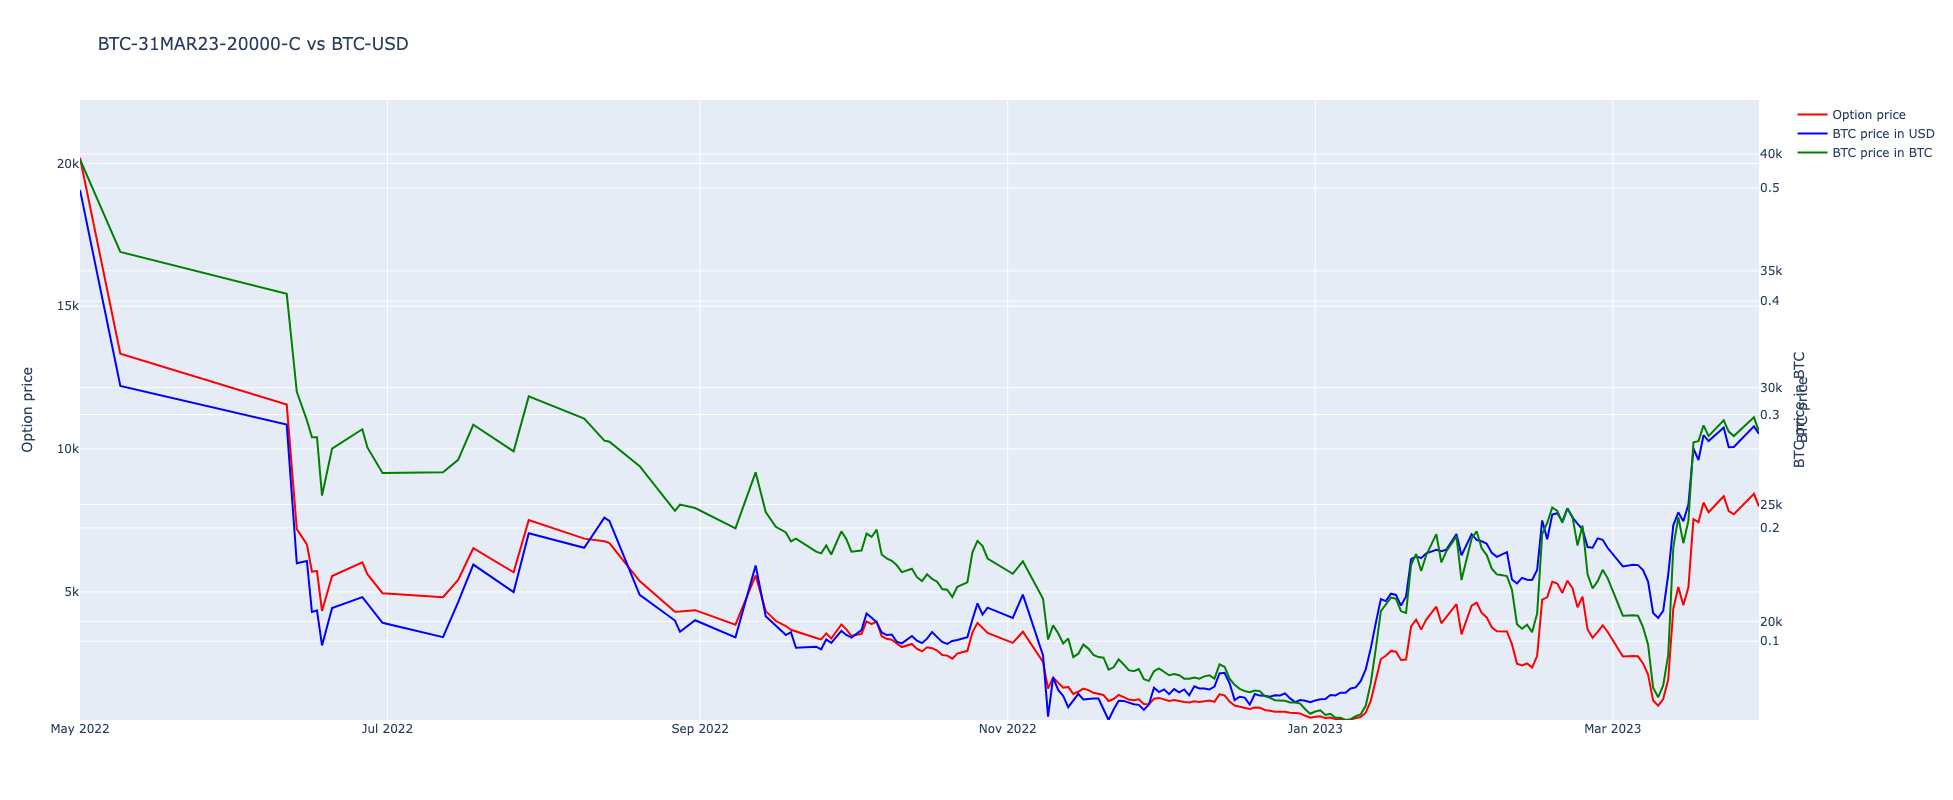

In [169]:

showFig('get_last_trades_by_BTC-31MAR23-20000-C.json', 'BTC-31MAR23-20000-C vs BTC-USD')

### Strike $24k turns out to be USD 4,465 in the money

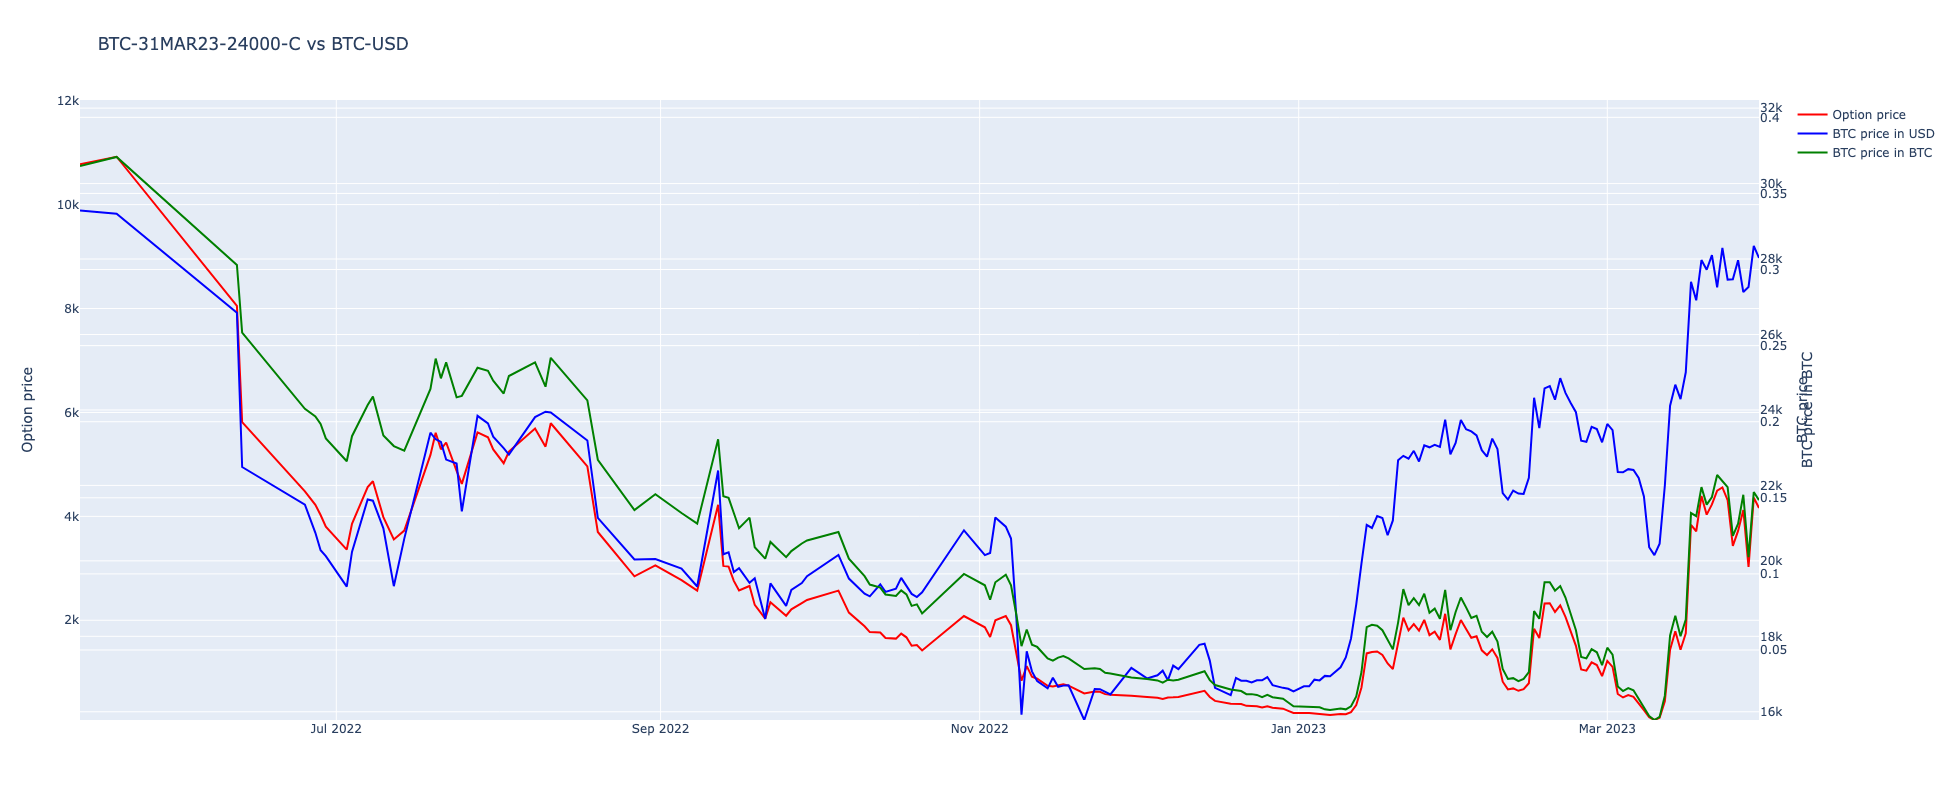

In [170]:
showFig('get_last_trades_by_BTC-31MAR23-24000-C.json', 'BTC-31MAR23-24000-C vs BTC-USD')

### Strike $28k turns out to be USD465 in the money

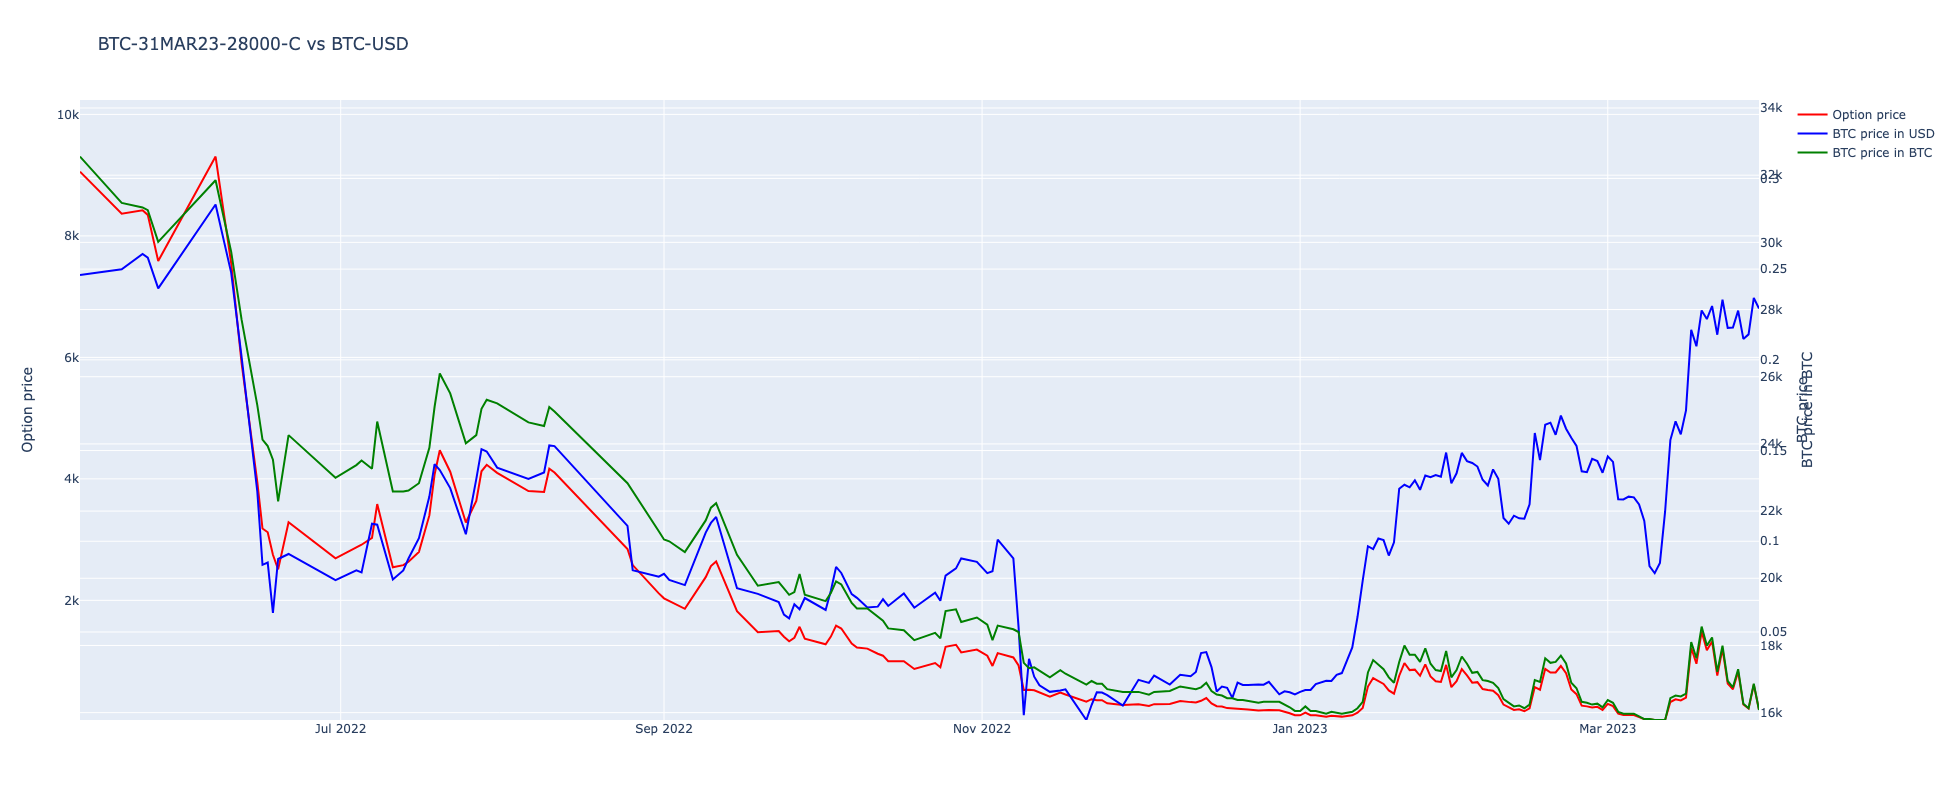

In [171]:
showFig('get_last_trades_by_BTC-31MAR23-28000-C.json', 'BTC-31MAR23-28000-C vs BTC-USD')

### Strike $27k, turns out to be USD1,465 in the money

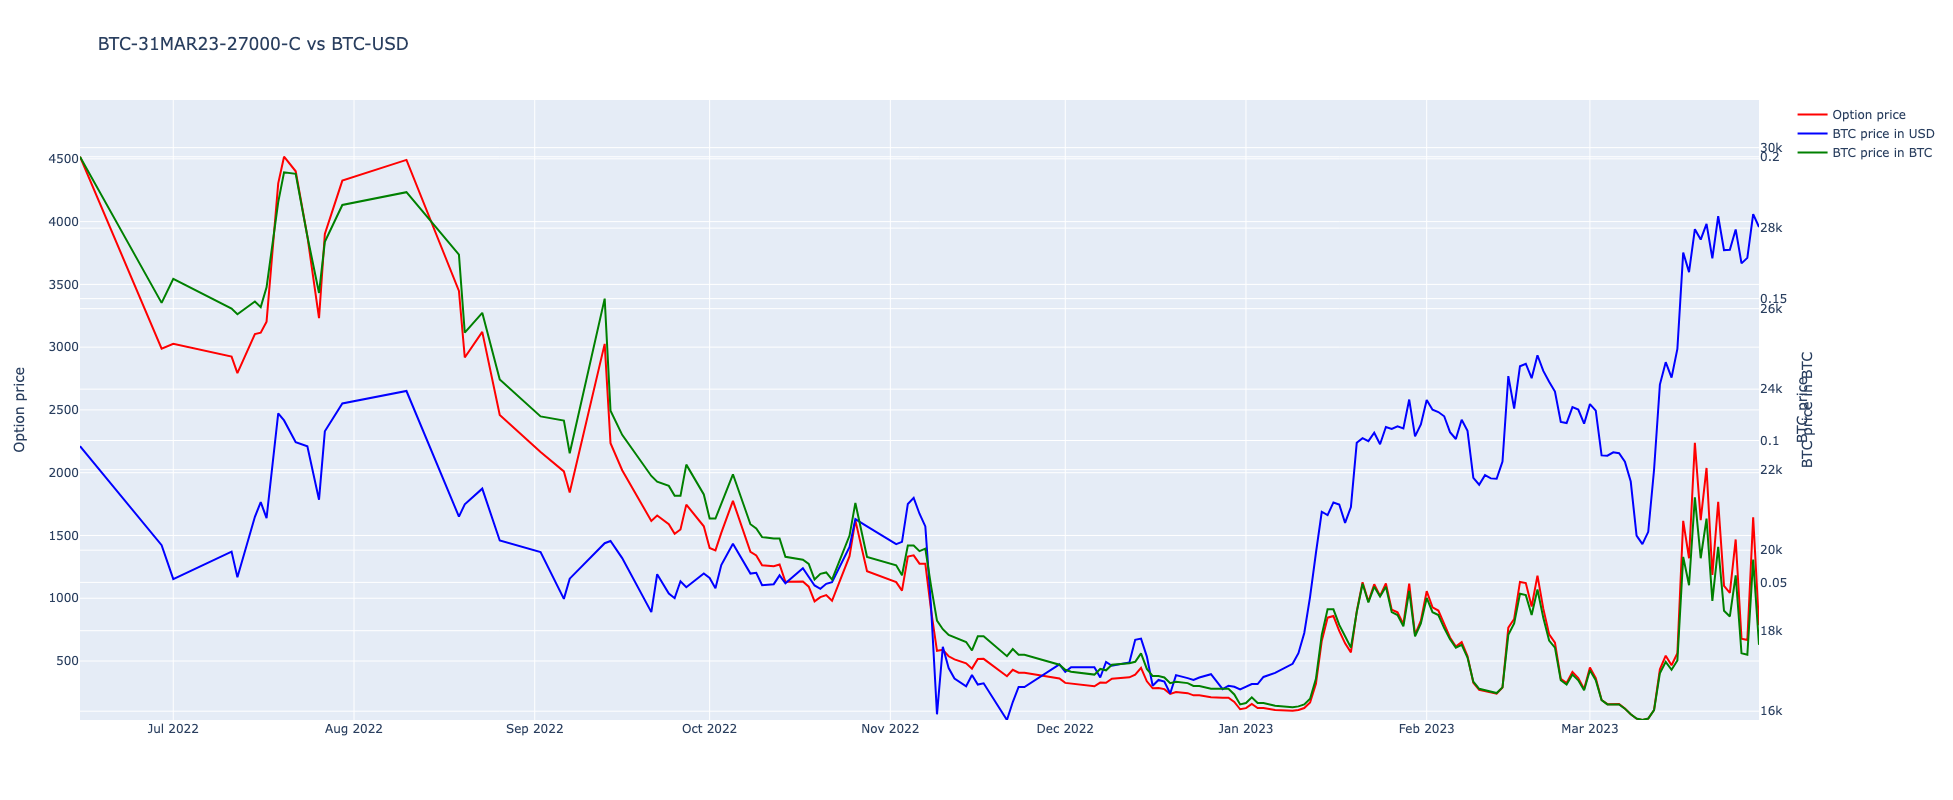

In [172]:
showFig('get_last_trades_by_BTC-31MAR23-27000-C.json', 'BTC-31MAR23-27000-C vs BTC-USD')

### Strike $30k, ends up out of the money

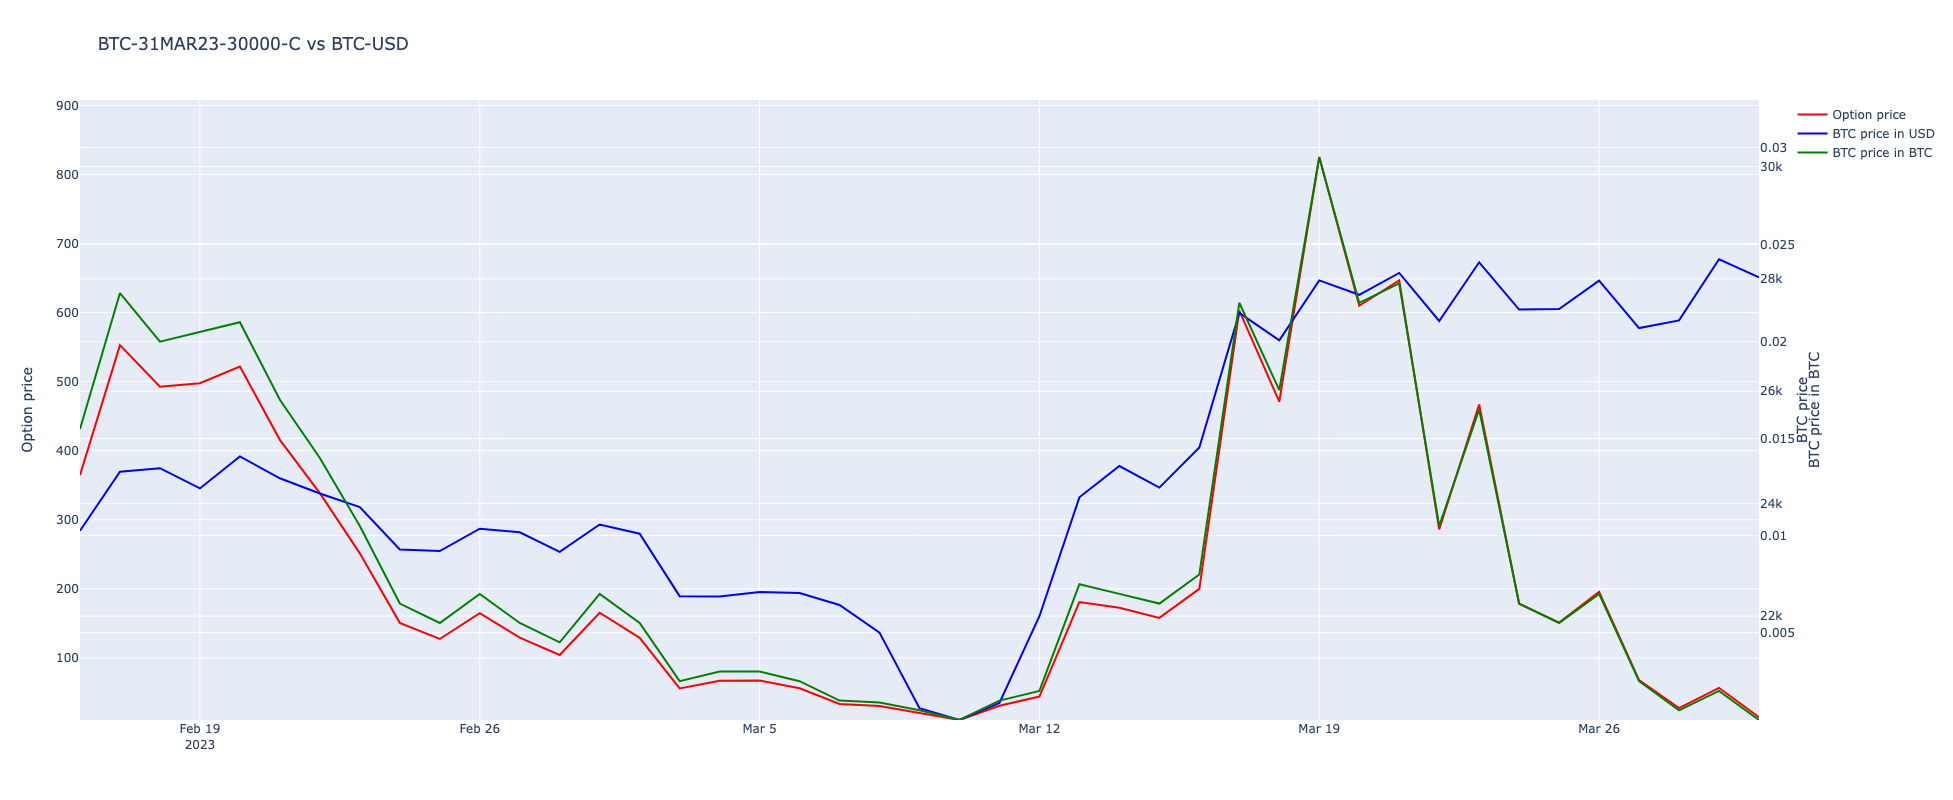

In [173]:
showFig('get_last_trades_by_BTC-31MAR23-30000-C.json', 'BTC-31MAR23-30000-C vs BTC-USD')

### Strike $35k, ends up way out of the money

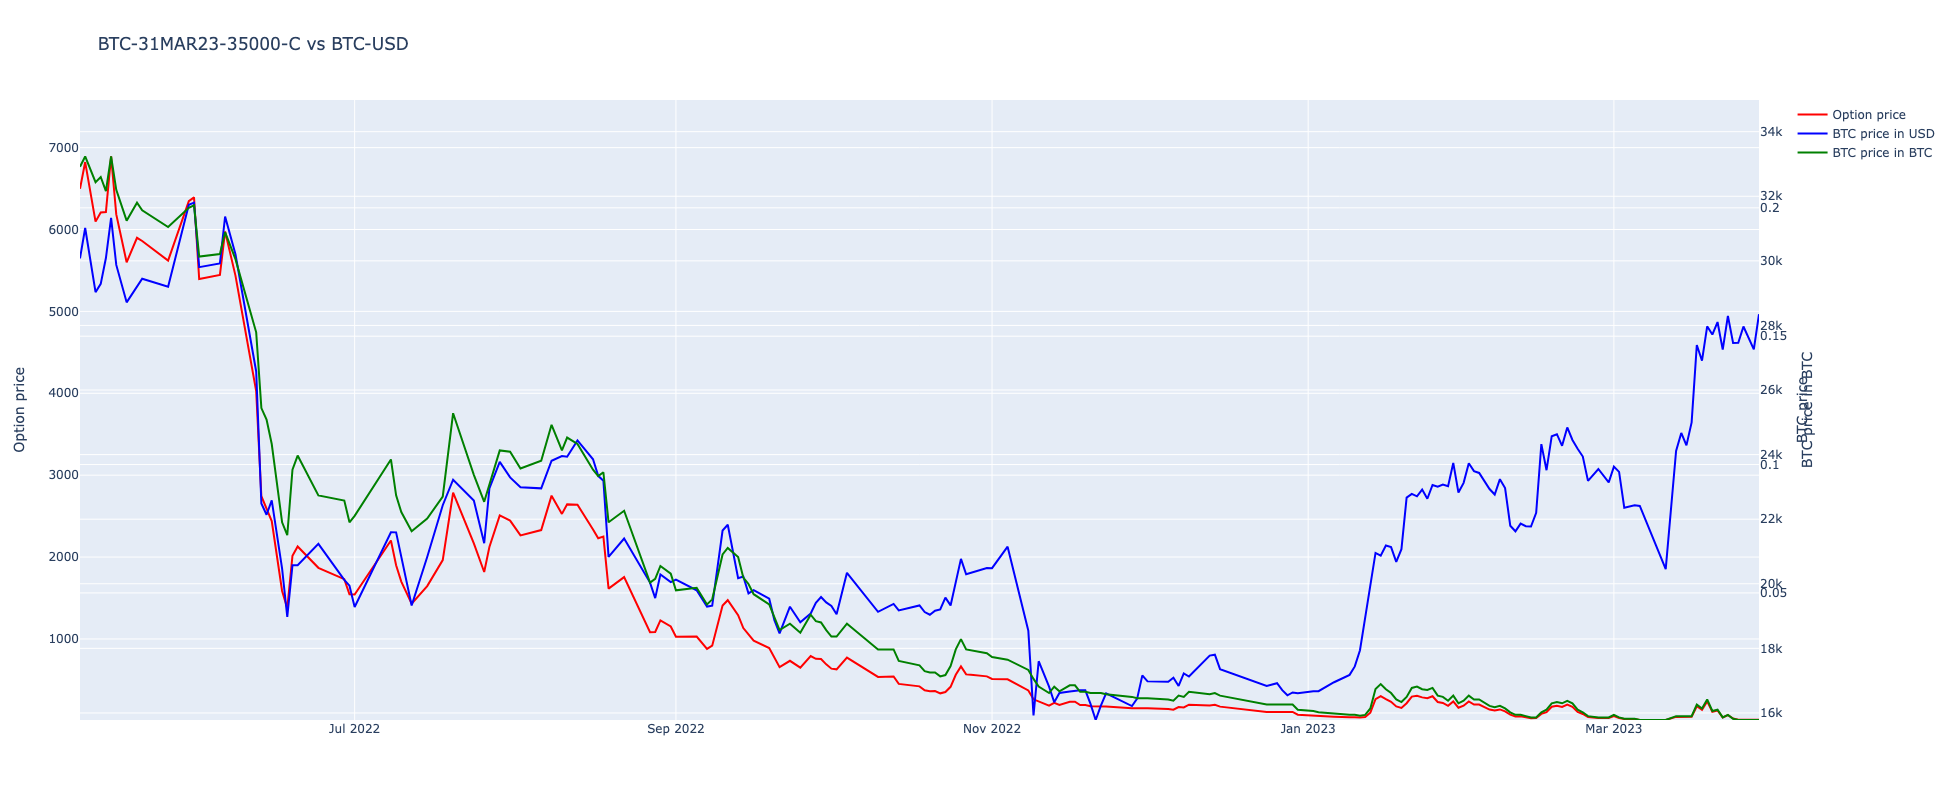

In [174]:
showFig('get_last_trades_by_BTC-31MAR23-35000-C.json', 'BTC-31MAR23-35000-C vs BTC-USD')